# NLP Project - Political line classification

This project consists in classifying the political line of a short text, typically a tweet. The dabase used is the one used for [INSERT LINK]. It is exclusively made of tweets posted during the French 2017 presidential election. 

The objective of this project is to classify the tweets into one of the five following classes: far-right, right, center, left, far-left. 

We use different types of models, ranging from the most simple ones (such as logistic regression) to more sophisticated one (fine-tuning CamemBERT).

# Set up on Google Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
#os.chdir('drive/My Drive/ENSAE/NLP')
os.chdir('drive/My Drive/NLP')

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
def boldprint(s):
    print('\033[1m' + s + '\033[0m')

# 1. Data importation and description

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random 

np.random.seed(0)
random.seed(0)

In [0]:
df = pd.read_csv('data/base_tweets_propre_sans_emoji.csv')

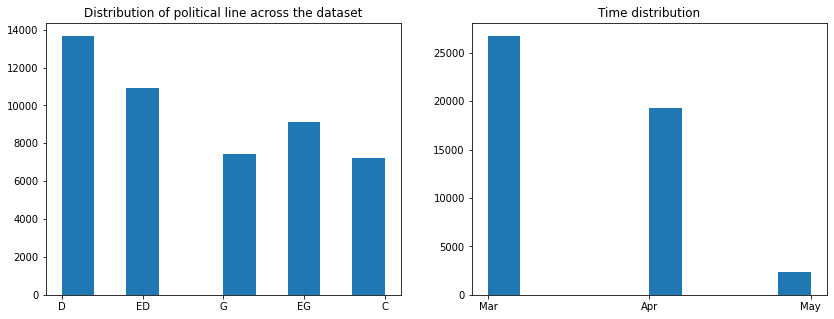

In [0]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.hist(df['couleur_politique'])
ax1.set_title('Distribution of political line across the dataset')
ax2.hist(df['mois'])
ax2.set_title('Time distribution')
plt.show()

Our dataset is approximately balanced, even if we have a slightly dominant class (Right). 

In [0]:
pd.crosstab(df.mois, df.couleur_politique)

couleur_politique,C,D,ED,EG,G
mois,,,,,
Apr,3604,5229,4426,3609,2402
Mar,2752,8382,5504,5269,4834
May,861,57,1005,243,200


# 2. Classification with random splitting

We take a first approach where we split the data without any time consideration (ie evenly across March, April and May).

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from utils.evaluation import evaluate,plot_confusion_matrix
from utils.utils import random_split_dataset,time_split_dataset
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
Xtrain,ytrain,Xval,yval,Xtest,ytest,label_map = random_split_dataset(df,validation=True)

## 2.1 Classification without deep learning

We will evaluate a selection of models in order to have a benchmark for the deep learning methods we will use afterwards.

In [0]:
classifiers = {'Logistic regression':LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                                                        intercept_scaling=1, l1_ratio=None, max_iter=200,
                                                        multi_class='auto', n_jobs=None, penalty='l2',
                                                        random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                                                        warm_start=False),
               'SVM': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
                          decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
                          max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
                          verbose=False),
               'Random Forest': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                                                        criterion='gini', max_depth=700, max_features='log2',
                                                        max_leaf_nodes=None, max_samples=None,
                                                        min_impurity_decrease=0.0, min_impurity_split=None,
                                                        min_samples_leaf=1, min_samples_split=500,
                                                        min_weight_fraction_leaf=0.0, n_estimators=600,
                                                        n_jobs=None, oob_score=False, random_state=0, verbose=0,
                                                        warm_start=False),
               'Multi Layer Perceptron':MLPClassifier(hidden_layer_sizes= (50,50,50),
                                        activation= 'relu',
                                        solver = 'adam',
                                        batch_size = 32,
                                        alpha = 0.01,
                                        learning_rate = 'adaptive', 
                                        random_state=0)}

We use the following code to evaluate the models on the validation set. 

In [0]:
for name,clf in classifiers.items():
    clf.fit(Xtrain,ytrain)
    ypred = clf.predict(Xval)
    boldprint('--------------'+name+'--------------')
    print(evaluate(yval,ypred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


--------------Logistic regression--------------
   accuracy   recall  precision  f1-score
0   0.94522  0.94281   0.947772  0.945142
--------------SVM--------------
   accuracy    recall  precision  f1-score
0  0.952351  0.948774   0.955501   0.95189
--------------Random Forest--------------
   accuracy    recall  precision  f1-score
0  0.943979  0.937025   0.956169  0.945292
--------------Multi Layer Perceptron--------------
   accuracy    recall  precision  f1-score
0  0.947597  0.946857   0.947898  0.947338


We only show here, for clarity sake, the results with the best hyperparameters.

In [0]:
sorted_labels = [label_map[key] for key in sorted(label_map)]
sorted_labels

['C', 'D', 'ED', 'EG', 'G']

In [0]:
Xtrain_ = vstack((Xtrain, Xval)) 
ytrain_ = hstack((ytrain, yval)).T

------Logit------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 5.5s
              precision    recall  f1-score   support

           C       0.95      0.93      0.94      1443
           D       0.93      0.96      0.94      2734
          ED       0.96      0.95      0.96      2187
          EG       0.98      0.96      0.97      1825
           G       0.95      0.94      0.94      1487

    accuracy                           0.95      9676
   macro avg       0.95      0.95      0.95      9676
weighted avg       0.95      0.95      0.95      9676



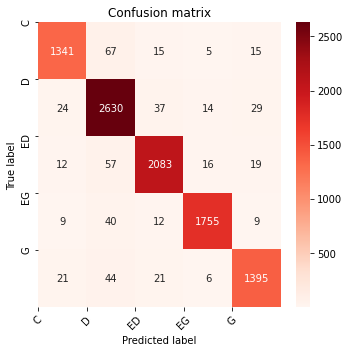

------SVM------
Training time: 184.7s
              precision    recall  f1-score   support

           C       0.97      0.93      0.95      1443
           D       0.93      0.97      0.95      2734
          ED       0.96      0.96      0.96      2187
          EG       0.98      0.96      0.97      1825
           G       0.96      0.94      0.95      1487

    accuracy                           0.96      9676
   macro avg       0.96      0.95      0.96      9676
weighted avg       0.96      0.96      0.96      9676



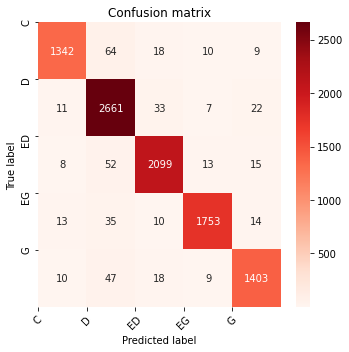

------RF------
Training time: 89.9s
              precision    recall  f1-score   support

           C       0.98      0.91      0.94      1443
           D       0.89      0.98      0.93      2734
          ED       0.97      0.95      0.96      2187
          EG       0.97      0.96      0.96      1825
           G       0.98      0.91      0.94      1487

    accuracy                           0.95      9676
   macro avg       0.96      0.94      0.95      9676
weighted avg       0.95      0.95      0.95      9676



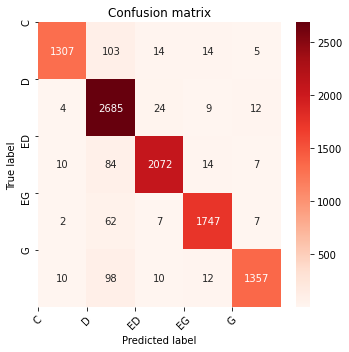

In [0]:
for name,clf in classifiers.items():
    boldprint('--------------'+name+'--------------')
    start = time.time()
    clf.fit(Xtrain,ytrain)
    end = time.time()
    print(f'Training time: {end-start:.1f}s')
    ypred = clf.predict(Xtest)
    print(classification_report(ytest,ypred,target_names = sorted_labels))
    plot_confusion_matrix(ytest,ypred,label_map=label_map)

## 2.2 Classification using custom neural networks 

In [0]:
!pip install transformers

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer, CamembertModel
import pandas as pd
from torch.utils.data import DataLoader
import pdb
from sklearn.metrics import accuracy_score
from utils.tweet_dataset import TweetDatasetBERT,build_tweet_dataset
from utils.evaluation import get_predictions
from classifiers import CamembertClassifier, RNN, CNN,train

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
dftrain,ytrain,dfval,yval,dftest,ytest,label_map = random_split_dataset(df,validation=True,deep=True)

In [0]:
train_set,tokenizer = build_tweet_dataset(dftrain)
val_set, _ = build_tweet_dataset(dfval,tokenizer)
test_set, _ = build_tweet_dataset(dftest,tokenizer)

train_loader = DataLoader(train_set,batch_size = 32,num_workers = 5,drop_last=True)
val_loader = DataLoader(val_set,batch_size = 32,num_workers = 5,drop_last=True)
test_loader = DataLoader(test_set,batch_size = 1,num_workers = 5,drop_last=False)

### 2.2.1 Custom LSTM

We implement a relatively shallow LSTM (2 layers), which uses no pretrained embedding. 

In [0]:
vocab_size = tokenizer.num_words+1
output_size = 5
embedding_dim = 128
hidden_dim = 100
n_layers = 2
model = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
scheduler = None

Iteration 100 of epoch 1 complete. Loss : 1.5219147205352783, Accuracy 0.28125 
Iteration 200 of epoch 1 complete. Loss : 1.3682001829147339, Accuracy 0.5 
Iteration 300 of epoch 1 complete. Loss : 1.4423495531082153, Accuracy 0.46875 
Iteration 400 of epoch 1 complete. Loss : 1.6409143209457397, Accuracy 0.15625 
Iteration 500 of epoch 1 complete. Loss : 1.5497667789459229, Accuracy 0.28125 
Iteration 600 of epoch 1 complete. Loss : 1.301340937614441, Accuracy 0.65625 
Iteration 700 of epoch 1 complete. Loss : 1.4723342657089233, Accuracy 0.375 
Iteration 800 of epoch 1 complete. Loss : 1.494044542312622, Accuracy 0.375 
Iteration 900 of epoch 1 complete. Loss : 1.4676028490066528, Accuracy 0.4375 
EVALUATION Validation set : mean loss 1.4589365811537434 || mean accuracy 0.26189982891082764
Iteration 100 of epoch 2 complete. Loss : 1.5724538564682007, Accuracy 0.28125 
Iteration 200 of epoch 2 complete. Loss : 1.4166492223739624, Accuracy 0.5 
Iteration 300 of epoch 2 complete. Loss :

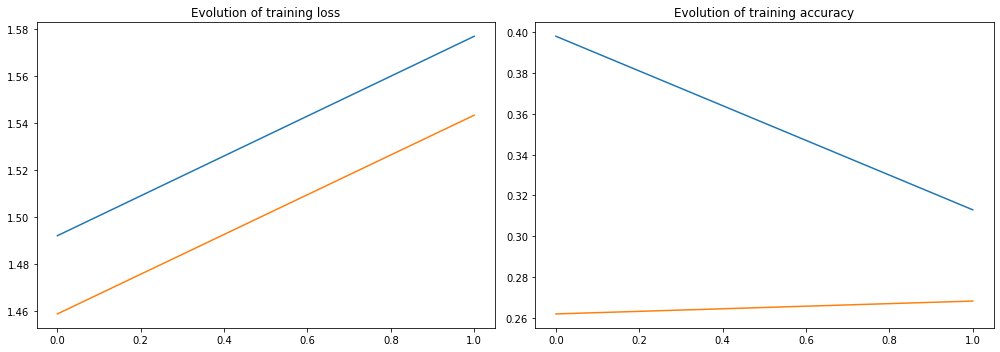

In [0]:
train(model, 'rnn',criterion, optimizer,scheduler, train_loader, val_loader, n_epochs=2, print_every=100, gpu=True)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           C       0.00      0.00      0.00      1443
           D       0.32      0.94      0.48      2734
          ED       0.40      0.32      0.36      2187
          EG       0.00      0.00      0.00      1825
           G       0.00      0.00      0.00      1487

    accuracy                           0.34      9676
   macro avg       0.14      0.25      0.17      9676
weighted avg       0.18      0.34      0.22      9676



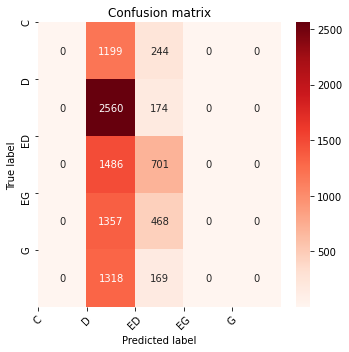

In [0]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,model_type='rnn')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

### 2.2.2 Custom Convolutional Network

Convolutional networks are quite commonly used in the literature of NLP problems, so we implement a custom convolutional network. 

In [0]:
max_features = 8000
embed_dim = 128
model = CNN(max_features,embed_dim)
model = model.to(device)

CNN(
  (embedding): Embedding(8000, 128)
  (convs1): ModuleList(
    (0): Conv2d(1, 64, kernel_size=(1, 128), stride=(1, 1))
    (1): Conv2d(1, 64, kernel_size=(2, 128), stride=(1, 1))
    (2): Conv2d(1, 64, kernel_size=(3, 128), stride=(1, 1))
    (3): Conv2d(1, 64, kernel_size=(5, 128), stride=(1, 1))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=256, out_features=5, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, verbose=True)

Iteration 100 of epoch 1 complete. Loss : 0.8884888887405396, Accuracy 0.9375 
Iteration 200 of epoch 1 complete. Loss : 0.01595088094472885, Accuracy 1.0 
Iteration 300 of epoch 1 complete. Loss : 0.6128931045532227, Accuracy 0.96875 
Iteration 400 of epoch 1 complete. Loss : 0.7157066464424133, Accuracy 0.96875 
Iteration 500 of epoch 1 complete. Loss : 1.6657708883285522, Accuracy 0.96875 
Iteration 600 of epoch 1 complete. Loss : 0.0006060600280761719, Accuracy 1.0 
Iteration 700 of epoch 1 complete. Loss : 0.0, Accuracy 1.0 
Iteration 800 of epoch 1 complete. Loss : 0.09957744181156158, Accuracy 0.96875 
Iteration 900 of epoch 1 complete. Loss : 0.0006290674209594727, Accuracy 1.0 
EVALUATION Validation set : mean loss 8.206678748895593 || mean accuracy 0.22247517108917236
Iteration 100 of epoch 2 complete. Loss : 3.32464599609375, Accuracy 0.96875 
Iteration 200 of epoch 2 complete. Loss : 0.014715611934661865, Accuracy 1.0 
Iteration 300 of epoch 2 complete. Loss : 0.02880591899

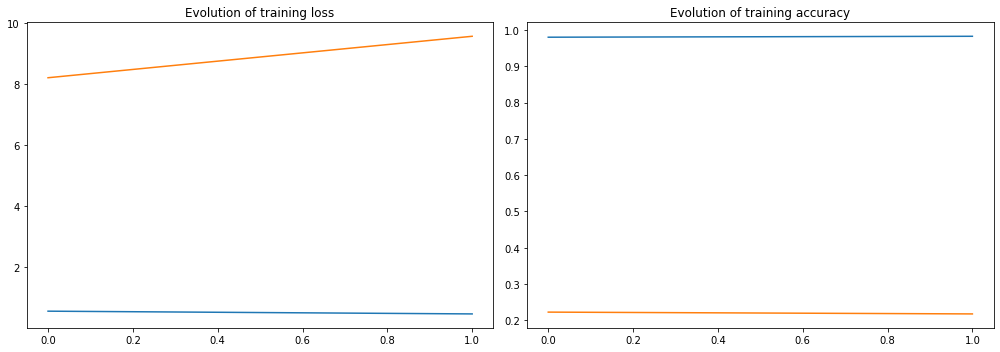

In [0]:
train(model, 'cnn',criterion, optimizer,scheduler, train_loader, val_loader, n_epochs=2, print_every=100, gpu=True)

              precision    recall  f1-score   support

           C       0.92      0.92      0.92      1443
           D       0.91      0.95      0.93      2734
          ED       0.94      0.95      0.94      2187
          EG       0.98      0.95      0.96      1825
           G       0.94      0.90      0.92      1487

    accuracy                           0.94      9676
   macro avg       0.94      0.93      0.94      9676
weighted avg       0.94      0.94      0.94      9676



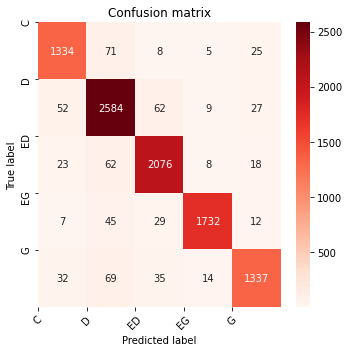

In [0]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'cnn')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

## 2.3 Classification using CamemBERT

In [0]:
dftrain,ytrain,dfval,yval,dftest,ytest,label_map = random_split_dataset(df,validation=True,deep=True)

### 2.3.1 Training

In [0]:
#Creating instances of training and validation set
train_set = TweetDatasetBERT(df = dftrain, maxlen = 50, model_name='camembert-base')
val_set = TweetDatasetBERT(df = dfval, maxlen = 50, model_name='camembert-base')
test_set = TweetDatasetBERT(df = dftest, maxlen = 50, model_name='camembert-base')

#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 32, num_workers = 5,drop_last=True)
val_loader = DataLoader(val_set, batch_size = 32, num_workers = 5,drop_last=True)
test_loader = DataLoader(test_set,batch_size=1,num_workers=5,drop_last=False)

In [0]:
model = CamembertClassifier('camembert-base')
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
scheduler = None

Iteration 100 of epoch 1 complete. Loss : 1.6659659147262573, Accuracy 0.15625 
Iteration 200 of epoch 1 complete. Loss : 1.494121789932251, Accuracy 0.5 
Iteration 300 of epoch 1 complete. Loss : 1.519334077835083, Accuracy 0.40625 
Iteration 400 of epoch 1 complete. Loss : 1.6268603801727295, Accuracy 0.15625 
Iteration 500 of epoch 1 complete. Loss : 1.5794845819473267, Accuracy 0.28125 
Iteration 600 of epoch 1 complete. Loss : 1.4947808980941772, Accuracy 0.5 
Iteration 700 of epoch 1 complete. Loss : 1.6079844236373901, Accuracy 0.125 
Iteration 800 of epoch 1 complete. Loss : 1.5774513483047485, Accuracy 0.28125 
Iteration 900 of epoch 1 complete. Loss : 1.574285864830017, Accuracy 0.28125 
EVALUATION Validation set : mean loss 1.581156177631277 || mean accuracy 0.2824917137622833
Iteration 100 of epoch 2 complete. Loss : 1.6526890993118286, Accuracy 0.21875 
Iteration 200 of epoch 2 complete. Loss : 1.504313588142395, Accuracy 0.5 
Iteration 300 of epoch 2 complete. Loss : 1.52

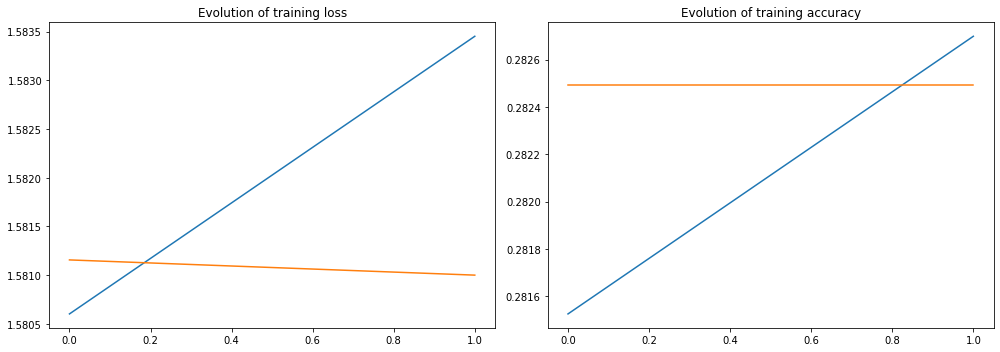

In [0]:
train(model, 'bert',criterion, optimizer,scheduler, train_loader, val_loader, n_epochs=2, print_every=100, gpu=True)

### 2.3.2 Evaluation

For the evaluation part, since we are interested in recall, precision and f1-score, we cannot simply compute an average over batches. 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           C       0.00      0.00      0.00      1443
           D       0.28      1.00      0.44      2734
          ED       0.00      0.00      0.00      2187
          EG       0.00      0.00      0.00      1825
           G       0.00      0.00      0.00      1487

    accuracy                           0.28      9676
   macro avg       0.06      0.20      0.09      9676
weighted avg       0.08      0.28      0.12      9676



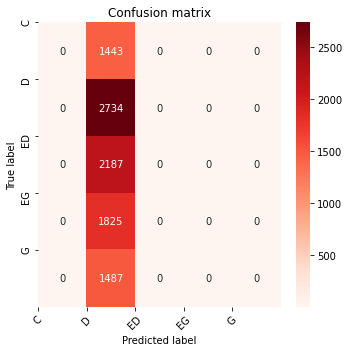

In [0]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'bert')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

### 2.3.3 Interpretation

For this part, we want to visualize which parts of text caught the attention of the classifier. This gives us an insight about how the model works.

In [0]:
from utils.interpretation import get_last_layer_attention,display_attention,visualize_layer_attention

In [0]:
sample = train_set[1]
mean_attn,tokens,attn_data = get_last_layer_attention(model,train_set.tokenizer,sample)

We visualize the attention of the 12 attention heads of the encoder's last layer (which is the one given in input ot the classifier part of our model).

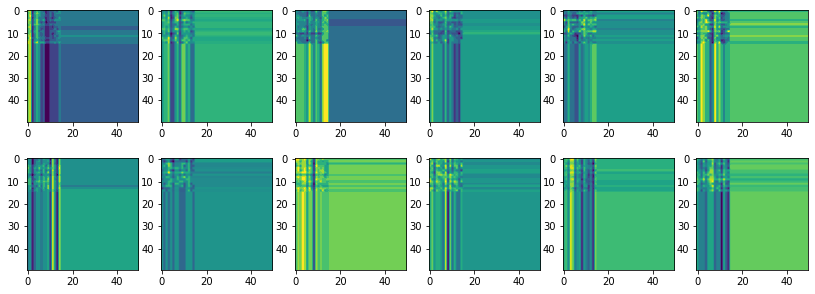

In [0]:
visualize_layer_attention(attn_data['layer11'].cpu().detach().numpy())

Below is a more compact and more explicit visualization of these same attentions. it is obtained by averaging over attentions heads and rows, getting rid of useless tokens (start, end and padding tokens) and summing the attentions over tokens which are parts of the same word. Let's notice however that this procedure does not give us the ties between words of the sentence, but only which words are important and have strong ties with a certain number of other words.

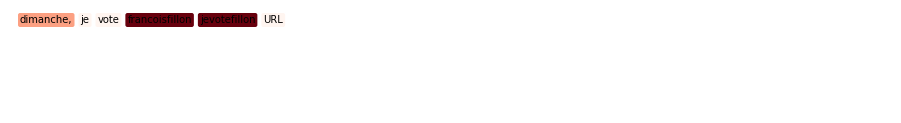

In [0]:
display_attention(tokens,mean_attn,train_set.tokenizer)

In most cases this points to significant words in the sentences, such as "progress", "solidarity", "deregulation", which may mean that some political parties use them more than others (which is intuitive). Also, when the name of the candidate is present in the sentence, it attracts the attention of the model.

# 3. Classification with time-wise splitting

In this second approach, we split the data time-wise: we train on March and we test on April and May. We expect the performances of our models to drop, especially those which are based on the count vectorizer, which will face many out-of-vocabulary words in the test set. The reason for that is that our tweets are highly contextual: they respond to events happening in a short time window before the tweet. 

In [0]:
Xtrain,ytrain,Xval,yval,Xtest,ytest,label_map = time_split_dataset(df,validation=True)

## 3.1 Classification without deep learning

In [0]:
classifiers = {'Logistic regression':LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                                                        intercept_scaling=1, l1_ratio=None, max_iter=200,
                                                        multi_class='auto', n_jobs=None, penalty='l2',
                                                        random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                                                        warm_start=False),
               'SVM': SVC(C=10,random_state=0),
               'Random Forest': RandomForestClassifier(n_estimators=300,random_state=0),
               'Multi Layer Perceptron':MLPClassifier(hidden_layer_sizes= (100,),
                                                      activation= 'relu',
                                                      solver = 'adam',
                                                      batch_size = 32,
                                                      alpha = 0.03,
                                                      learning_rate = 'adaptive', 
                                                      random_state=0)}

In [0]:
for name,clf in classifiers.items():
    clf.fit(Xtrain,ytrain)
    ypred = clf.predict(Xval)
    boldprint('--------------'+name+'--------------')
    print(evaluate(yval,ypred))

In [0]:
Xtrain_ = vstack((Xtrain, Xval)) 
ytrain_ = hstack((ytrain, yval)).T

In [0]:
for name,clf in classifiers.items():
    boldprint('--------------'+name+'--------------')
    start = time.time()
    clf.fit(Xtrain,ytrain)
    end = time.time()
    print(f'Training time: {end - start:.1f}s')
    ypred = clf.predict(Xtest)
    print(classification_report(ytest,ypred,target_names = sorted_labels))
    plot_confusion_matrix(ytest,ypred,label_map=label_map)

We can observe that the models perform really worse than with the random split. It probably comes from the preprocessing: the political context evolves with time, so that we must face a lot of out-of-vocabulary words. 

## 3.2 Classification using custom neural networks

In [0]:
dftrain,ytrain,dfval,yval,dftest,ytest,label_map = time_split_dataset(df,validation=True,deep=True)

In [0]:
train_set,tokenizer = build_tweet_dataset(dftrain)
val_set, _ = build_tweet_dataset(dfval,tokenizer)
test_set, _ = build_tweet_dataset(dftest,tokenizer)

train_loader = DataLoader(train_set,batch_size = 32,num_workers = 5,drop_last=True)
val_loader = DataLoader(val_set,batch_size = 32,num_workers = 5,drop_last=True)
test_loader = DataLoader(test_set,batch_size = 1,num_workers = 5,drop_last=False)

### 3.2.1 Custom LSTM

In [0]:
vocab_size = len(word_ix) + 1
output_size = 5
embedding_dim = 128
hidden_dim = 100
n_layers = 2
model = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [0]:
train(model, 'rnn',criterion, optimizer,scheduler, train_loader, val_loader, n_epochs=10, print_every=100, gpu=True)

In [0]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'rnn')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

### 3.2.2 Custom CNN

In [0]:
max_features = 8000
embed_dim = 128
model = CNN(max_features,embed_dim)
model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 2, verbose=True)

In [0]:
train(model, 'cnn',criterion, optimizer,scheduler, train_loader, val_loader, n_epochs=10, print_every=100, gpu=True)

In [0]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'cnn')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

The observations for neural networks are the same than for the first models we used: the performance dropped. 

## 3.3 Using CamemBERT

### 3.3.1 Training

In [0]:
#Creating instances of training and validation set
train_set = TweetDatasetBERT(df = dftrain, maxlen = 50, model_name='camembert-base')
val_set = TweetDatasetBERT(df = dfval, maxlen = 50, model_name='camembert-base')
test_set = TweetDatasetBERT(df = dftest, maxlen = 50, model_name='camembert-base')

#Creating intsances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 32, num_workers = 5,drop_last=True)
val_loader = DataLoader(val_set, batch_size = 32, num_workers = 5,drop_last=True)
test_loader = DataLoader(test_set,batch_size=1,num_workers=5,drop_last=False)

In [0]:
model = CamembertClassifier('camembert-base')
model = model = model.to(device)

In [0]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr = 1e-4)
scheduler = None

In [0]:
train(model, 'bert',criterion, optimizer,scheduler, train_loader, val_loader, n_epochs=10, print_every=100, gpu=True)

### 3.3.2 Evaluation

In [0]:
model.eval()
ytest,ypred = get_predictions(model,test_loader,'bert')
print(classification_report(ytest,ypred,target_names = sorted_labels))
plot_confusion_matrix(ytest,ypred,label_map=label_map)

Despite CamemBERT being context insensitive (since it does not face out-of-vocabulary words), it still performs poorly compared to the first part. This is, in our opinion, still linked to the context: the model does not know how to map words from a new context to political lines. This suggests that there are very few "patterns" (ie words or phrases used specifically by one or two political parties) in the politician discourse which would be used in a majority of contexts, and upon which we could build a classifier. 

### 3.3.3 Interpretation

In [0]:
sample = train_set[1]
mean_attn,tokens,attn_data = get_last_layer_attention(model,train_set.tokenizer,sample)

In [0]:
display_attention(tokens,mean_attn,train_set.tokenizer)